In [1]:
pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.3 MB/s eta 0:00:00


In [11]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Traigo las librerias del google para realizar la conexion con el drive
from google.colab import files
from google.colab import drive

In [4]:
drive.mount("/content/drive") # Se realiza la peticion para conexion a la cuenta de google drive

Mounted at /content/drive


In [15]:
pathOrigen = r"/content/drive/MyDrive/Diversa/Urbansafe/urbansafe_v1.csv".replace("\\","/")
pathFinal = r"/content/drive/MyDrive/Diversa/Urbansafe/nodos_expandidosV2.csv".replace("\\","/")

In [6]:
def expandir_coordenadas(coordenadas, distancia=350):
    coordenadas_expandidas = []

    # Se crea un DataFrame vacío para almacenar las coordenadas expandidas
    df_expandido = pd.DataFrame(columns=['latitude', 'longitude', 'node_type', 'id'])

    for coord in coordenadas:
        # Obtener el id, la latitud y la longitud de la coordenada actual (con esto se hara math con la fuente original para traer los demas campos)
        id_coordenada = coord['id']
        latitud = coord['latitude']
        longitud = coord['longitude']

        G = ox.graph_from_point((latitud, longitud), dist=distancia, network_type='all')

        # Obtener las coordenadas de los nodos cercanos
        coordenadas_nodos = [(G.nodes[nodo]['y'], G.nodes[nodo]['x']) for nodo in G.nodes()]

        coordenadas_expandidas.extend(coordenadas_nodos)

        # Se crea un DataFrame temporal para las coordenadas expandidas de esta iteración
        df_temporal = pd.DataFrame(coordenadas_nodos, columns=['latitude', 'longitude'])

        # Asignar el id correspondiente a todas las filas del DataFrame temporal
        df_temporal['node_type'] = 'secundaria'
        df_temporal['id'] = id_coordenada

        df_expandido = pd.concat([df_expandido, df_temporal])

    return df_expandido


In [10]:
df = pd.read_csv(pathOrigen, sep='|')


inputCoord = []

for _, row in df.iterrows():
    misFilas = {
        'id': row['index'],
        'latitude': row['latitude'],
        'longitude': row['longitude']
    }

    inputCoord.append(misFilas)


# Convertir la lista en un nuevo DataFrame
df_input = pd.DataFrame(inputCoord)
valor = 'principal'

df_input.insert(0, 'node_type', valor)

In [8]:
# En esta linea hago el llamado a la funcion
coordenadas_expandidas = expandir_coordenadas(inputCoord)

# Se realiza la juntura con el df original para extraer otras variables adicionales
df_outPut = pd.DataFrame(coordenadas_expandidas)
df_outPut = df_outPut.loc[:, ['node_type','id', 'latitude', 'longitude']]
df_res = pd.concat([df_input, df_outPut], ignore_index=True)
df_res = df_res.drop_duplicates()

In [12]:
columnas = ['index','id', 'country', 'country_code', 'city'] # Se seleccionan las variables que se van a mostrar en el output final
df_orig = df[columnas]
df_final = df_orig.merge(df_res, left_on='index', right_on='id', how='inner')
df_final = df_final.drop(columns=['id_y']).rename(columns={'id_x': 'id'})

In [16]:
# Guardar el DataFrame resultante en un archivo CSV en la carpeta compartida en google drive
df_final.to_csv(pathFinal, sep='|', index=False)

ANALISIS EXPLORATORIO DE DATOS

In [20]:
# 1. Visión General
print("Primeras filas del DataFrame:")
print(df_final.head())

# 2. Resumen Estadístico
print("\nResumen Estadístico:")
df_final.describe()

Primeras filas del DataFrame:
  index         id    country country_code     city   node_type   latitude  \
0     1  ARGS20031  Argentina          ARG  Rosario   principal -32.961405   
1     1  ARGS20031  Argentina          ARG  Rosario  secundaria -32.959729   
2     1  ARGS20031  Argentina          ARG  Rosario  secundaria -32.958462   
3     1  ARGS20031  Argentina          ARG  Rosario  secundaria -32.960805   
4     1  ARGS20031  Argentina          ARG  Rosario  secundaria -32.960559   

   longitude  
0 -60.684841  
1 -60.687142  
2 -60.681169  
3 -60.681762  
4 -60.683139  

Resumen Estadístico:


latitude    longitude
count  8922.000000  8922.000000
mean      2.944974   -13.431233
std      15.951018    83.525642
min     -32.964864   -80.689780
25%      -2.886328   -78.461074
50%       6.168953   -75.559442
75%      13.736592   100.557079
max      21.992428   105.848645

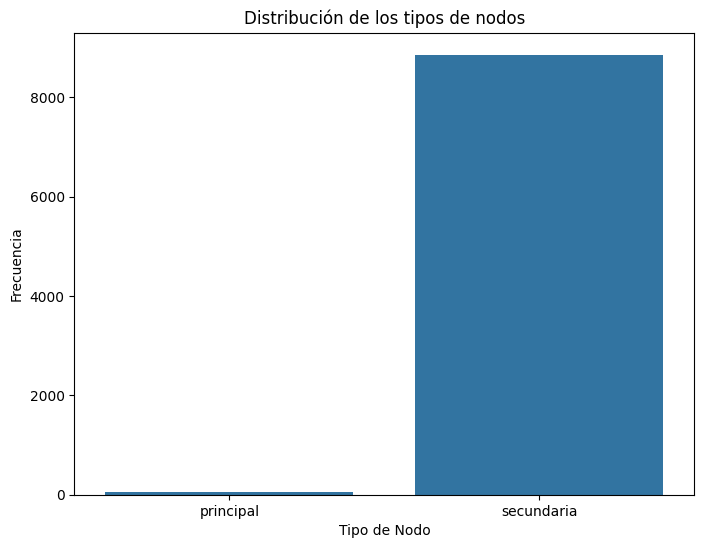

In [21]:
# 3. Distribución de Variables

# Distribución del tipo de nodos
plt.figure(figsize=(8, 6))
sns.countplot(x='node_type', data=df_res)
plt.title('Distribución de los tipos de nodos')
plt.xlabel('Tipo de Nodo')
plt.ylabel('Frecuencia')
plt.show()

Text(0.5, 1.0, 'Distribución de la Latitud')

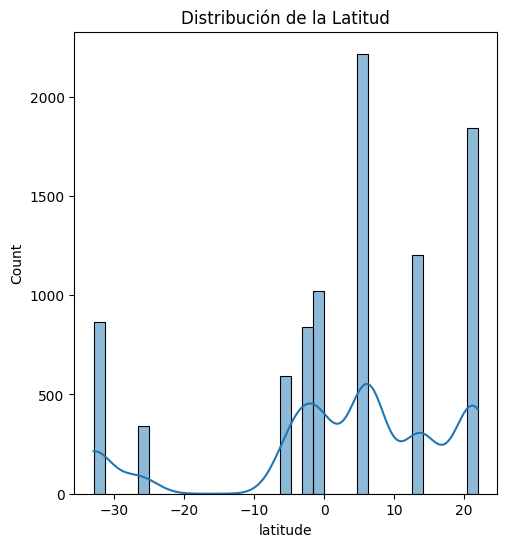

In [22]:
# Distribución de latitud y longitud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_res['latitude'], kde=True)
plt.title('Distribución de la Latitud')

Text(0.5, 1.0, 'Distribución de la Longitud')

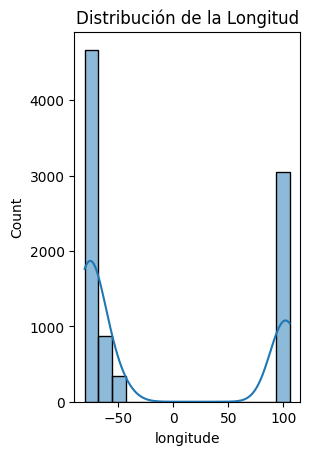

In [23]:
plt.subplot(1, 2, 2)
sns.histplot(df_res['longitude'], kde=True)
plt.title('Distribución de la Longitud')

     Country  Count
0   Colombia   2217
1    Ecuador   1857
2    Vietnam   1316
3  Tailandia   1205
4  Argentina    866
5       Peru    594
6    Myanmar    527
7     Brazil    340


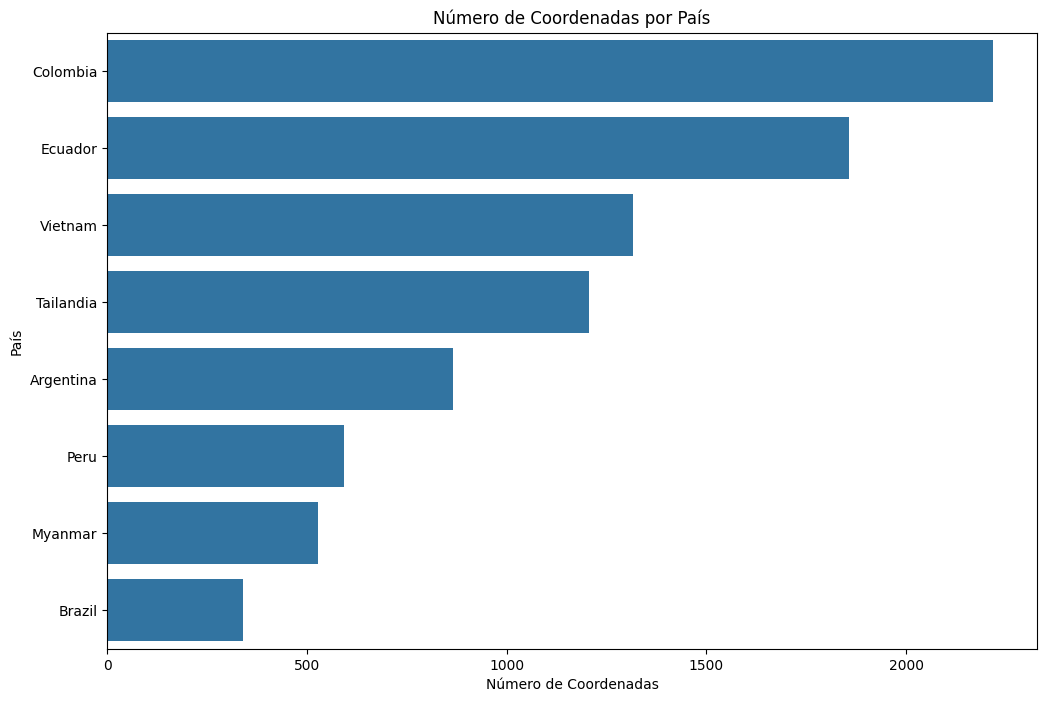

In [27]:
# 4. Contar las coordenadas por país
df_coordenadas_por_pais = df_final['country'].value_counts().reset_index()
df_coordenadas_por_pais.columns = ['Country', 'Count']

# Mostrar el DataFrame
print(df_coordenadas_por_pais)

# Visualización de las coordenadas por país
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Country', data=df_coordenadas_por_pais)
plt.title('Número de Coordenadas por País')
plt.xlabel('Número de Coordenadas')
plt.ylabel('País')
plt.show()

In [25]:
# 5. Visualización Geográfica
# Crear un mapa con folium
mapa = folium.Map(location=[df_res['latitude'].mean(), df_res['longitude'].mean()], zoom_start=12)

# Añadir los puntos al mapa
for _, row in df_res.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=2,
                        color='blue' if row['node_type'] == 'principal' else 'red',
                        fill=True,
                        fill_color='blue' if row['node_type'] == 'principal' else 'red').add_to(mapa)

# Guardar el mapa en un archivo HTML y mostrarlo
mapa.save('mapa_nodos.html')
mapa